# Extract the spectrum of CTIO Data in May 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne and Jérémy Neveu
- date   : May 31st 2017


- The goal is to extract the spectrum after the rotation.


-1) First the 1 orders are extracted. One must check the rotation is correct

-2) Check the 2 orders are well aligned along X by looking at the transverse profile : if you see two peaks this means the rotation is bad.

-3) For this the central star light must having been turned off.

In [5]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [6]:
print theNotebook

Extract_Spectrum


In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os
import sys
sys.path.append("../../common_tools/")
from scan_holo import *

In [8]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.2.0


In [9]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal
from matplotlib import cm

In [10]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.2.0


In [11]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [12]:
%load_ext Cython

In [13]:
from IPython.display import Image, display

In [14]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [15]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [16]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [17]:
def subplots_adjust(*args, **kwargs):
    """
    call signature::

      subplots_adjust(left=None, bottom=None, right=None, top=None,
                      wspace=None, hspace=None)

    Tune the subplot layout via the
    :class:`matplotlib.figure.SubplotParams` mechanism.  The parameter
    meanings (and suggested defaults) are::

      left  = 0.125  # the left side of the subplots of the figure
      right = 0.9    # the right side of the subplots of the figure
      bottom = 0.1   # the bottom of the subplots of the figure
      top = 0.9      # the top of the subplots of the figure
      wspace = 0.2   # the amount of width reserved for blank space between subplots
      hspace = 0.2   # the amount of height reserved for white space between subplots

    The actual defaults are controlled by the rc file
    """
    fig = gcf()
    fig.subplots_adjust(*args, **kwargs)
    draw_if_interactive()

### Output directory for images generated in the notebook view (not true fits images)

In [18]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [19]:
ensure_dir(dir_top_images) # create that directory

### Input fits file

In [20]:
inputdir="./rotated_fitsimages"
MIN_IMGNUMBER=26
MAX_IMGNUMBER=29
object_name='PNG321.0+3.9 June 5 2017'
SelectTagRe='^rotimg_20170605_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^rotimg_20170605_[0-9]+.fits$'
NBIMGPERROW=2

### output fits file

In [21]:
outputdir="./spectrum_fitsspec"

In [22]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [23]:
input_filelist=os.listdir(inputdir) 

In [24]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [25]:
input_filelist[:5]
print len(input_filelist)

4


In [26]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [27]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list

    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                num_str=re.findall(SelectTagRe,file)[0]
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages

In [28]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # Make the list

In [29]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [30]:
print indexes_files

[26 27 28 29]


In [31]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [32]:
sorted_numbers=indexes_files[sorted_indexes]

In [33]:
print sorted_indexes

[0 1 2 3]


In [34]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [35]:
#sorted_files

## Build full filename
----------------------------

In [36]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [37]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [38]:
print sorted_filenames.shape

(4,)


## Acces to data of  images
----------------------------------

In [39]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []
all_filt= []

In [40]:
%%cython

import numpy as np
from astropy.io import fits

def BuildImages(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawImages
    ===============
    """

    
    all_dates = []
    all_airmass = []
    all_images = []
    all_titles = []
    all_header = []
    all_expo = []
    all_filt= []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        filters = header['FILTERS'].split(' ')[1]
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        all_filt.append(filters)
        hdu_list.close()
        
    return all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt

In [41]:
all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

## Show images
-----------------------

In [42]:
len(all_images)

4

In [43]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os
    
right_edge = 1800    

def ShowImages(all_images,all_titles,object_name,dir_top_images,all_filt):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    It returns the x0, where the maximum occurs in the image
    """
    NBIMGPERROW=2
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)
    thex0 = []
  
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,6*MAXIMGROW))
    f.tight_layout()
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        image = all_images[index][:,0:right_edge]
        xprofile=np.sum(image,axis=0)
        x0=np.where(xprofile==xprofile.max())[0][0]
        thex0.append(x0)
        im=axarr[iy,ix].imshow(image,origin='lower',cmap='rainbow')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        axarr[iy,ix].text(1000.,275.,all_filt[index],verticalalignment='bottom', horizontalalignment='center',color='yellow', fontweight='bold',fontsize=16)
        
    title='Images of {}'.format(object_name)
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'intput_images.pdf')
    plt.savefig(figfilename)  
    
    return thex0

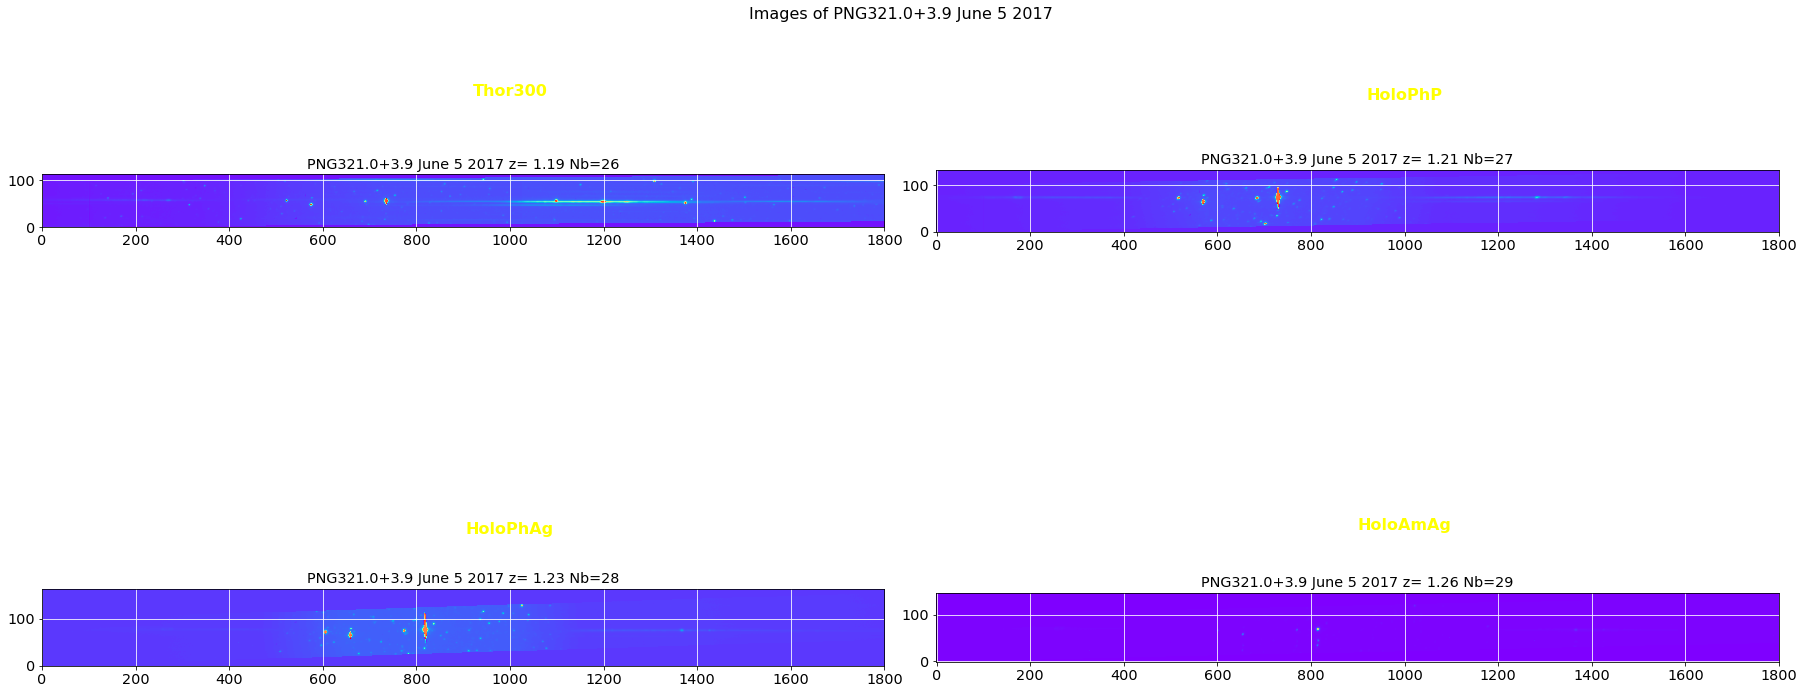

In [44]:
thex0=ShowImages(all_images,all_titles,object_name,dir_top_images,all_filt)

In [45]:
print thex0

[735, 730, 818, 815]


In [46]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os



def ShowOneOrder(all_images,all_titles,x0,object_name,all_expo,dir_top_images,figname):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    NBIMGPERROW=2
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,5*MAXIMGROW))
    f.tight_layout()
    
    #############################
    low_cut = 50
    up_cut = 100
    left_cut = 1000
    right_cut = 1800
    #############################
    
    for index in np.arange(0,NBIMAGES):
        
        print index, 'exposition time = ',all_expo[index] 
        
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        full_image=np.copy(all_images[index])
        
        if(all_expo[index]<=0 ): #special case of the first image
            reduc_image=full_image[low_cut:up_cut,left_cut:right_cut]  
        else:
            reduc_image=full_image[low_cut:up_cut,left_cut:right_cut]/all_expo[index] 
        X,Y=np.meshgrid(np.arange(0,reduc_image.shape[1]),np.arange(reduc_image.shape[0]))
        im = axarr[iy,ix].pcolormesh(X,Y,reduc_image, cmap='rainbow')
        #axarr[iy,ix].colorbar(im, orientation='vertical')
        axarr[iy,ix].axis([X.min(), X.max(), Y.min(), Y.max()]); axarr[iy,ix].grid(True)
        
        axarr[iy,ix].set_title(all_titles[index])
        
    
    title='Images of {}'.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,figname)
    #plt.savefig(figfilename) 

0 exposition time =  600.0
1 exposition time =  600.0
2 exposition time =  600.0
3 exposition time =  600.0


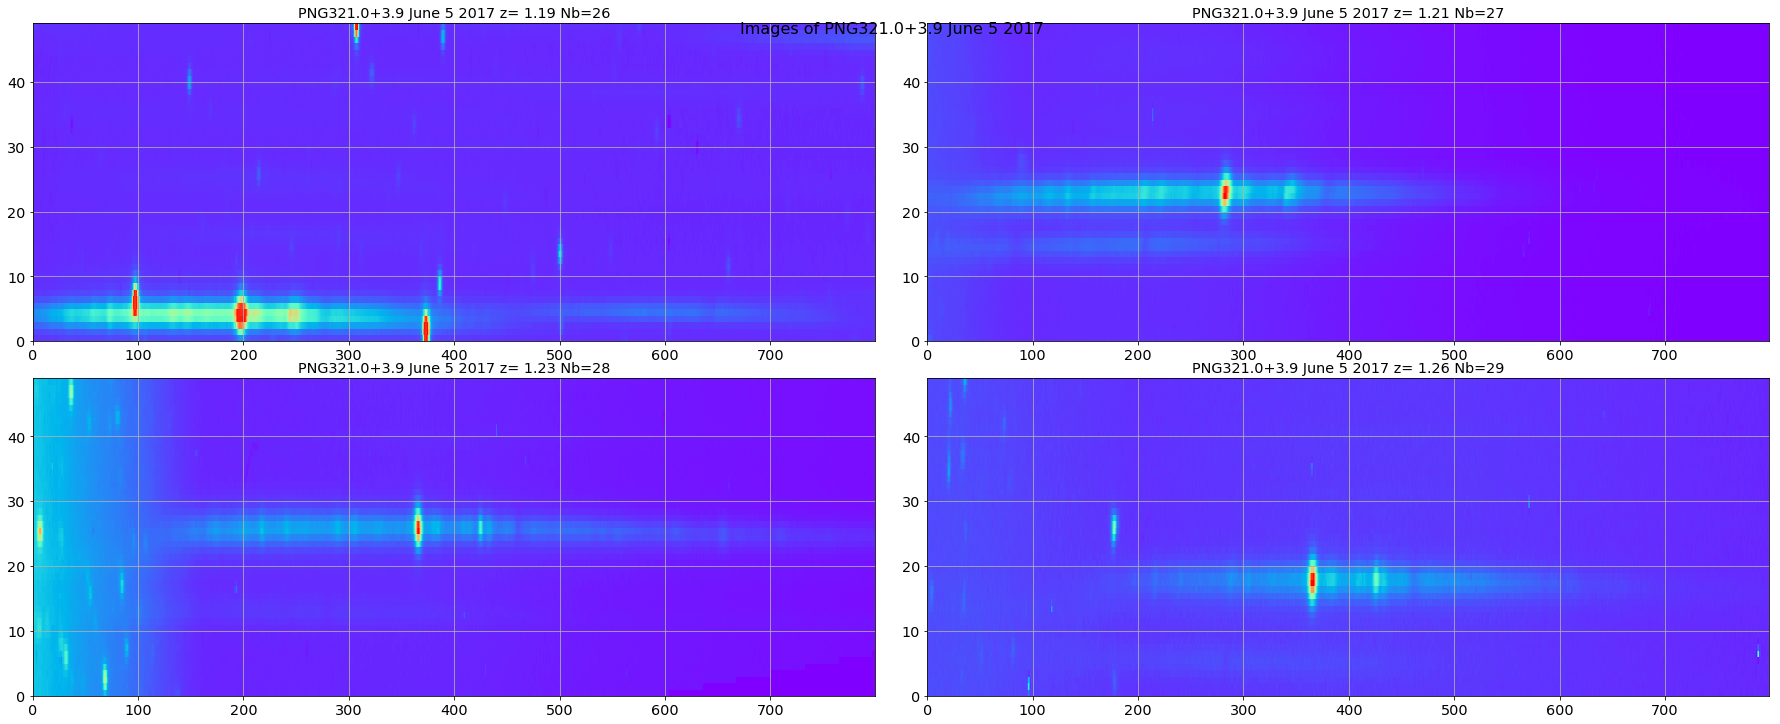

In [48]:
ShowOneOrder(all_images,all_titles,thex0,object_name,all_expo,dir_top_images,'firstorderright.pdf')

### Shows the transverse profile

In [49]:
DeltaX=600
w=20
ws=70

In [50]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def ShowTransverseProfile(all_images,x0,all_titles,object_name,all_expo,dir_top_images):
    """
    ShowTransverseProfile: Show the raw images without background subtraction
    =====================
    The goal is to see in y, where is the spectrum maximum. Returns they0
    
    """
    NBIMGPERROW=2
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)

    ### Criteria for spectrum region selection
    DeltaX=1000
    w=5       ##### width to sum the profile
    ws=80
    Dist=4*w
    right_edge = 1800
    ##################################
    
    thespectra= []
    thespectraUp=[]
    thespectraDown=[]
    
    they0 = []
    
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,6*MAXIMGROW))
    f.tight_layout()
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        data=np.copy(all_images[index])[:,0:right_edge]

        
        #data[:,x0-100:x0+100]=0 ## TURN OFF CENTRAL STAR
        
        if(all_expo[index]<=0):            
            yprofile=np.sum(data,axis=1)
        else:
            yprofile=np.sum(data,axis=1)/all_expo[index]
            
            
        ymin=100
        ymax=yprofile.max()
        y0=np.where(yprofile==ymax)[0][0]
        they0.append(y0)
        #y0 = they0[index]
        #im=axarr[iy,ix].imshow(data,vmin=-10,vmax=50)
        axarr[iy,ix].semilogy(yprofile)
        axarr[iy,ix].semilogy([y0,y0],[ymin,ymax],'r-')
        axarr[iy,ix].semilogy([y0-w,y0-w],[ymin,ymax],'k-')
        axarr[iy,ix].semilogy([y0+w,y0+w],[ymin,ymax],'k-')
        
        ##########################################################
        #### Here extract the spectrum around the central star
        #####   Take the sum un bins along y
        #############################################################
        
        spectrum2D=np.copy(data[y0-w:y0+w,:])
        xprofile=np.sum(spectrum2D,axis=0)

        
        ### Lateral bands to remove sky background
        ### ---------------------------------------
        spectrum2DUp=np.copy(data[y0-w+Dist:y0+w+Dist,:])
        xprofileUp=np.median(spectrum2DUp,axis=0)*2.*float(w)

        spectrum2DDown=np.copy(data[y0-w-Dist:y0+w-Dist,:])
        xprofileDown=np.median(spectrum2DDown,axis=0)*2.*float(w)
        
        
        if(all_expo[index]<=0):
            thespectra.append(xprofile)
            thespectraUp.append(xprofileUp)
            thespectraDown.append(xprofileDown)
        else:  ################## HERE I NORMALISE WITH EXPO TIME ####################################
            thespectra.append(xprofile/all_expo[index])
            thespectraUp.append(xprofileUp/all_expo[index]) 
            thespectraDown.append(xprofileDown/all_expo[index]) 

        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].set_ylim([100,2e4])
        axarr[iy,ix].grid(True)
    title='Spectrum tranverse profile '.format(object_name)
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'transverse_profile.pdf')
    plt.savefig(figfilename)  
    
    return thespectra,thespectraUp,thespectraDown,they0

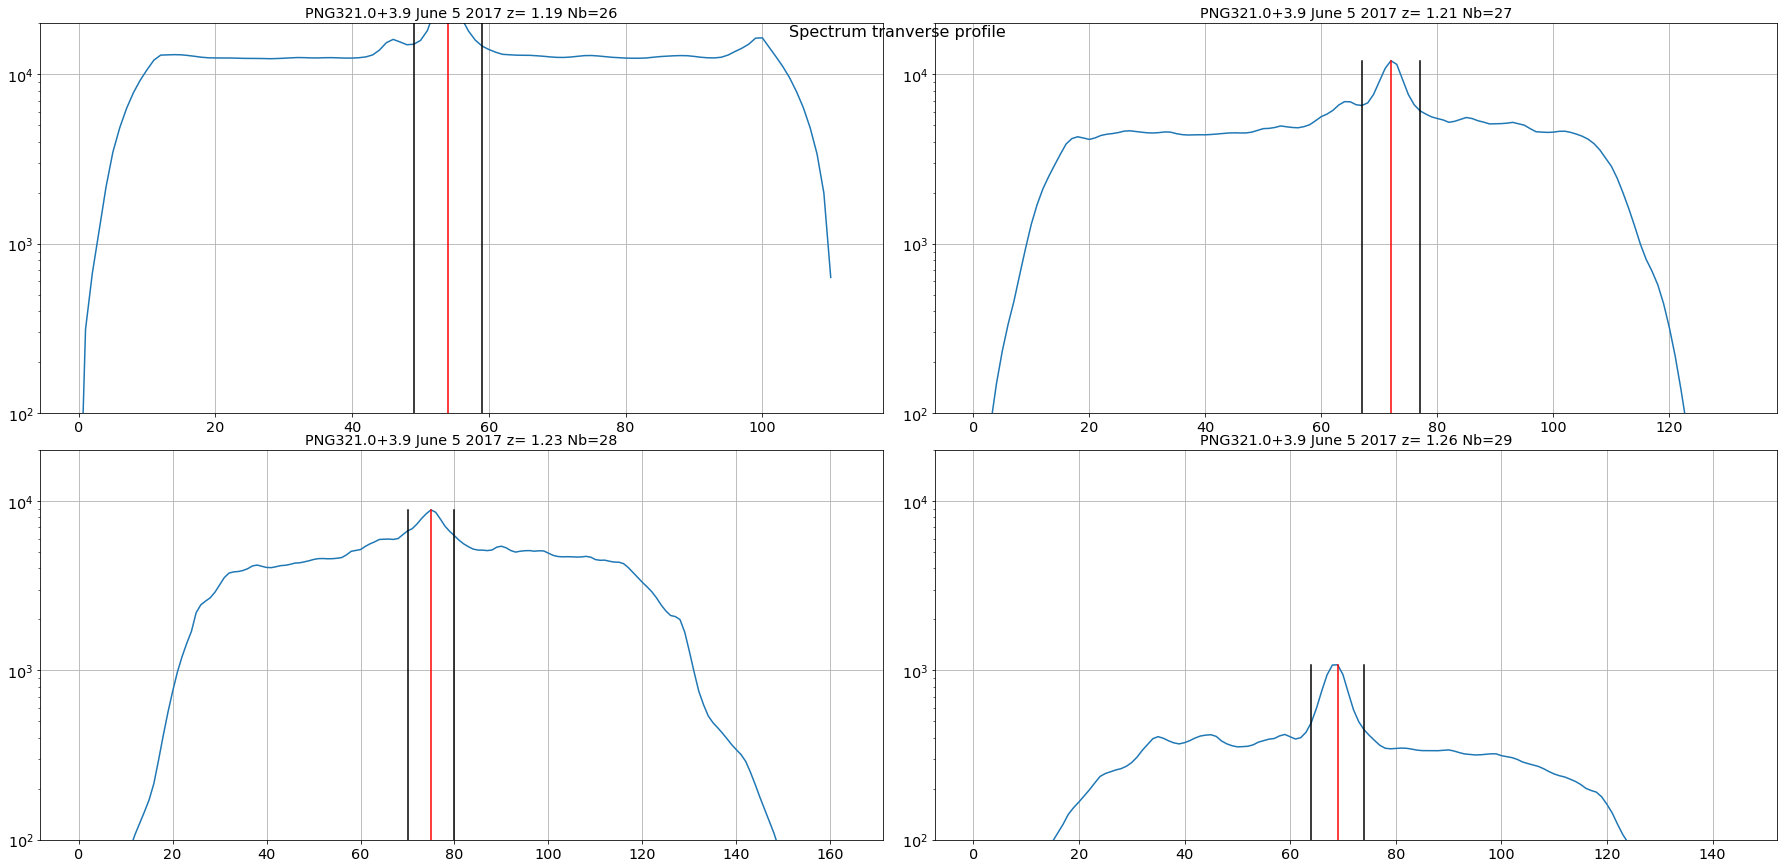

In [52]:
thespectra,thespectraUp,thespectraDown,they0=ShowTransverseProfile(all_images,thex0,all_titles,object_name,all_expo,dir_top_images)

In [53]:
print they0, thex0

[54, 72, 75, 69] [735, 730, 818, 815]


In [54]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def ShowRightOrder(all_images,thex0,they0,all_titles,object_name,all_expo,dir_top_images):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    NBIMGPERROW=2
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,6*MAXIMGROW))
    f.tight_layout()
    
    right_edge = 1800
    width_cut = 10
    
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        full_image=np.copy(all_images[index])[:,0:right_edge]
        y_0=they0[index]
        x_0=thex0[index]

        reduc_image=full_image[y_0-width_cut:y_0+width_cut,x_0+100:right_edge]/all_expo[index]
        
        X,Y=np.meshgrid(np.arange(0,reduc_image.shape[1]),np.arange(reduc_image.shape[0]))
        im = axarr[iy,ix].pcolormesh(X,Y,reduc_image, cmap='rainbow')
        #axarr[iy,ix].colorbar(im, orientation='vertical')
        axarr[iy,ix].axis([X.min(), X.max(), Y.min(), Y.max()]); axarr[iy,ix].grid(True)
        
        axarr[iy,ix].set_title(all_titles[index])
        
    
    title='Right part of spectrum of {} '.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,'rightorder.pdf')
    
    #plt.savefig(figfilename)  

In [55]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def ShowLeftOrder(all_images,thex0,they0,all_titles,object_name,all_expo,dir_top_images):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    NBIMGPERROW=2
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)
    #thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,6*MAXIMGROW))
    f.tight_layout()
    
    width_cut = 10

    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        full_image=np.copy(all_images[index])
        y_0=they0[index]
        x_0=thex0[index]
        
        
        reduc_image=full_image[y_0-width_cut:y_0+width_cut,0:x_0-100]/all_expo[index] 

        X,Y=np.meshgrid(np.arange(0,reduc_image.shape[1]),np.arange(reduc_image.shape[0]))
        im = axarr[iy,ix].pcolormesh(X,Y,reduc_image, cmap='rainbow',vmin=0,vmax=20)
        #axarr[iy,ix].colorbar(im, orientation='vertical')
        axarr[iy,ix].axis([X.min(), X.max(), Y.min(), Y.max()]); axarr[iy,ix].grid(True)
        
        axarr[iy,ix].set_title(all_titles[index])
        
    
    title='Left part of spectrum of '.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,'leftorder.pdf')
    #plt.savefig(figfilename)  

### Right order

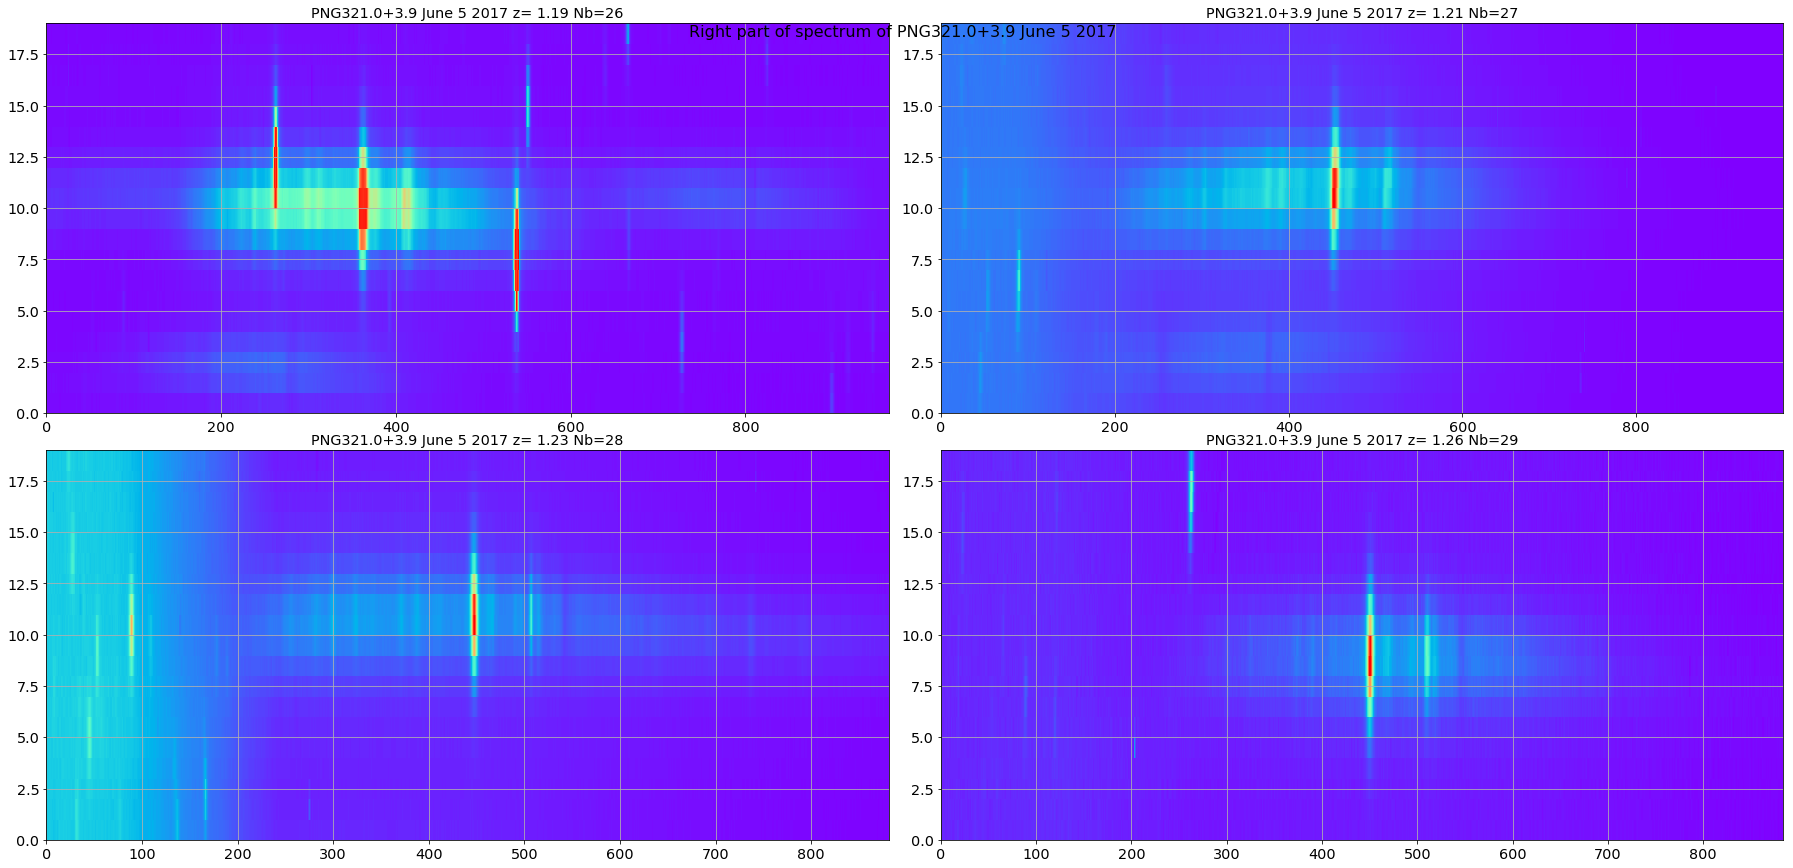

In [56]:
ShowRightOrder(all_images,thex0,they0,all_titles,object_name,all_expo,dir_top_images)

### Left order

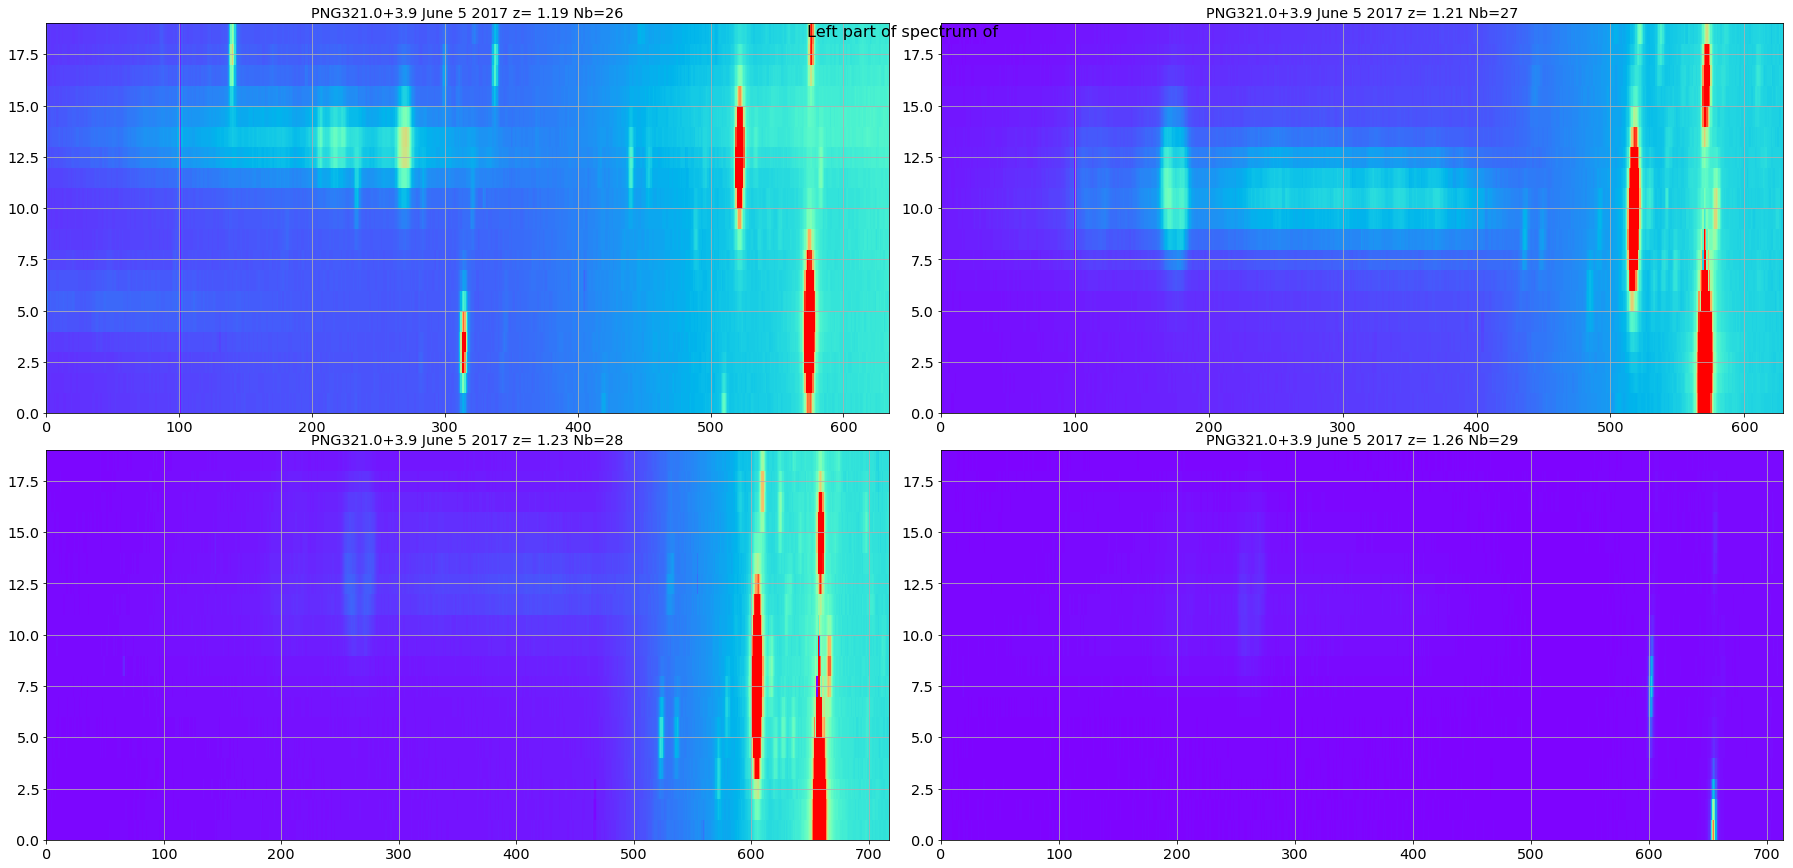

In [57]:
ShowLeftOrder(all_images,thex0,they0,all_titles,object_name,all_expo,dir_top_images)

In [58]:
def CleanBadPixels(spectraUp,spectraDown):
    
    Clean_Up= []
    Clean_Do = []
    Clean_Av = []
    eps=5.   # this is the minumum background Please check
    NBSPEC=len(spectraUp)
    for index in np.arange(0,NBSPEC):
        s_up=spectraUp[index]
        s_do=spectraDown[index]
    
        index_up=np.where(s_up<eps)
        index_do=np.where(s_do<eps)
        
        s_up[index_up]=s_do[index_up]
        s_do[index_do]=s_up[index_do]
        s_av=(s_up+s_do)/2.
        
        Clean_Up.append(s_up)
        Clean_Do.append(s_do)
        Clean_Av.append(s_av)
        
    return Clean_Up, Clean_Do,Clean_Av 

In [59]:
Clean_Up, Clean_Do,Clean_Av=CleanBadPixels(thespectraUp,thespectraDown) 

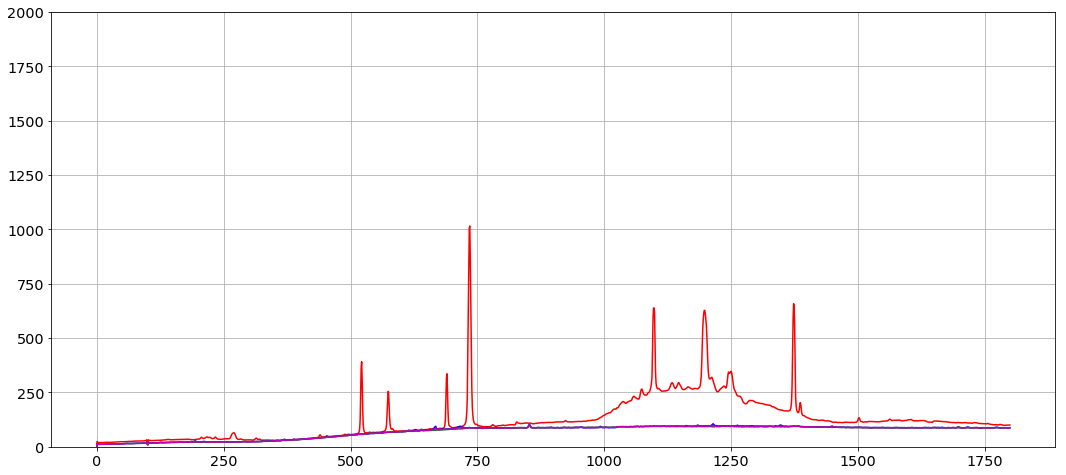

In [60]:
sel=0
plt.figure(figsize=(18,8))
plt.plot(thespectra[sel],'r-') 
plt.plot(Clean_Up[sel],'b-') 
plt.plot(Clean_Do[sel],'g-')
plt.plot(Clean_Av[sel],'m-')
plt.grid(True)
plt.ylim(0,2000.)
figfilename=os.path.join(dir_top_images,'bckg_sample.pdf')
plt.savefig(figfilename) 

In [61]:
def ShowLongitBackground(spectra,spectraUp,spectraDown,spectraAv,all_titles,object_name,dir_top_images):
    """
    Show the background to be removed to the spectrum
    """
    NBSPEC=len(spectra)
    MAXIMGROW=int(NBSPEC/NBIMGPERROW)
    
   
    
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,5*MAXIMGROW))
    f.tight_layout()
    for index in np.arange(0,NBSPEC):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        axarr[iy,ix].plot(spectra[index],'r-')
        axarr[iy,ix].plot(spectraUp[index],'b-')
        axarr[iy,ix].plot(spectraDown[index],'g-')
        axarr[iy,ix].plot(spectraAv[index],'m-')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,spectra[index][:1900].max()*1.2)
        axarr[iy,ix].text(1400.,spectra[index][:1900].max()*1.1, all_filt[index],verticalalignment='top', horizontalalignment='center',color='blue',fontweight='bold', fontsize=20)
    title='Longitudinal background Up/Down'.format(object_name)
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'background_longprofile.pdf')
    plt.savefig(figfilename)  
    

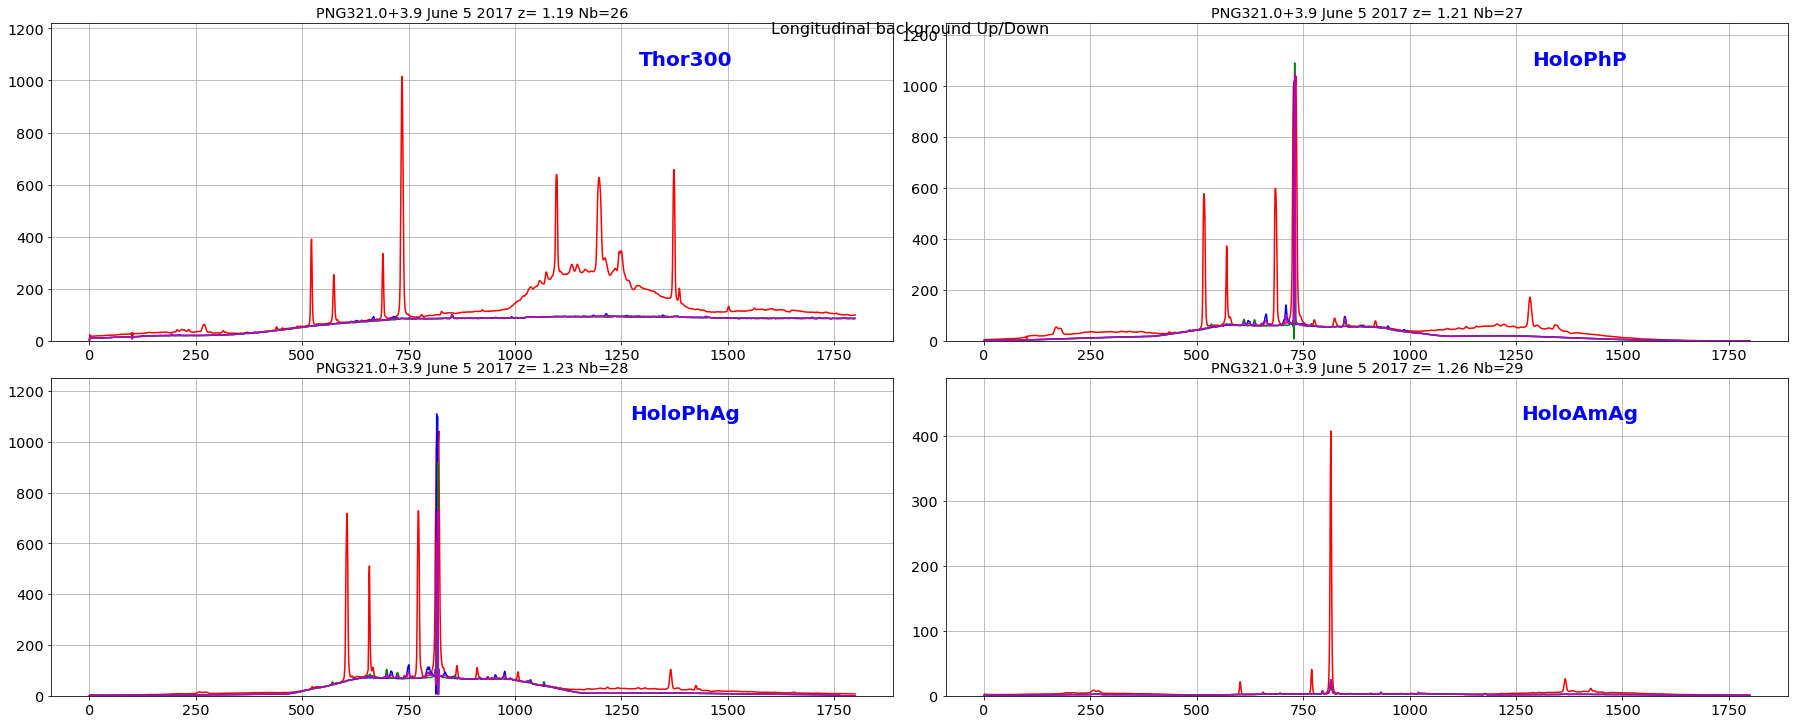

In [62]:
ShowLongitBackground(thespectra,Clean_Up,Clean_Do,Clean_Av,all_titles,object_name,dir_top_images)

In [63]:
def CorrectSpectrumFromBackground(spectra, background):
    """
    Background Subtraction
    """
    NBSPEC=len(spectra)
        
    corrected_spectra = []
    
    for index in np.arange(0,NBSPEC):
        corrspec=spectra[index]-background[index]
        corrected_spectra.append(corrspec)
    return corrected_spectra

In [64]:
thecorrspectra=CorrectSpectrumFromBackground(thespectra,Clean_Av)

In [65]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def ShowSpectrumProfile(spectra,all_titles,object_name,dir_top_images,all_filt):
    """
    ShowSpectrumProfile: Show the raw images without background subtraction
    =====================
    """
    NBIMGPERROW=2
    NBSPEC=len(spectra)
    MAXIMGROW=int(NBSPEC/NBIMGPERROW)
    #MaxY= [150.,150.,150.,5000.,1500.,1000.,5000.,5000.,500.,150.]
    
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,5*MAXIMGROW))
    f.tight_layout()
    for index in np.arange(0,NBSPEC):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        axarr[iy,ix].plot(spectra[index],'r-')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,spectra[index][:1800].max()*1.2)
        axarr[iy,ix].text(1000.,spectra[index][:1800].max()*1.1, all_filt[index],verticalalignment='top', horizontalalignment='center',color='blue',fontweight='bold', fontsize=20)
    
    title='Spectrum 1D profile and background Up/Down for {}'.format(object_name)
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'correctedspectrum_profile.pdf')
    plt.savefig(figfilename)  
    

#### Here below, we plot the latera (up and down ) background which has not been subtracted
For me the background remains flat and at zero


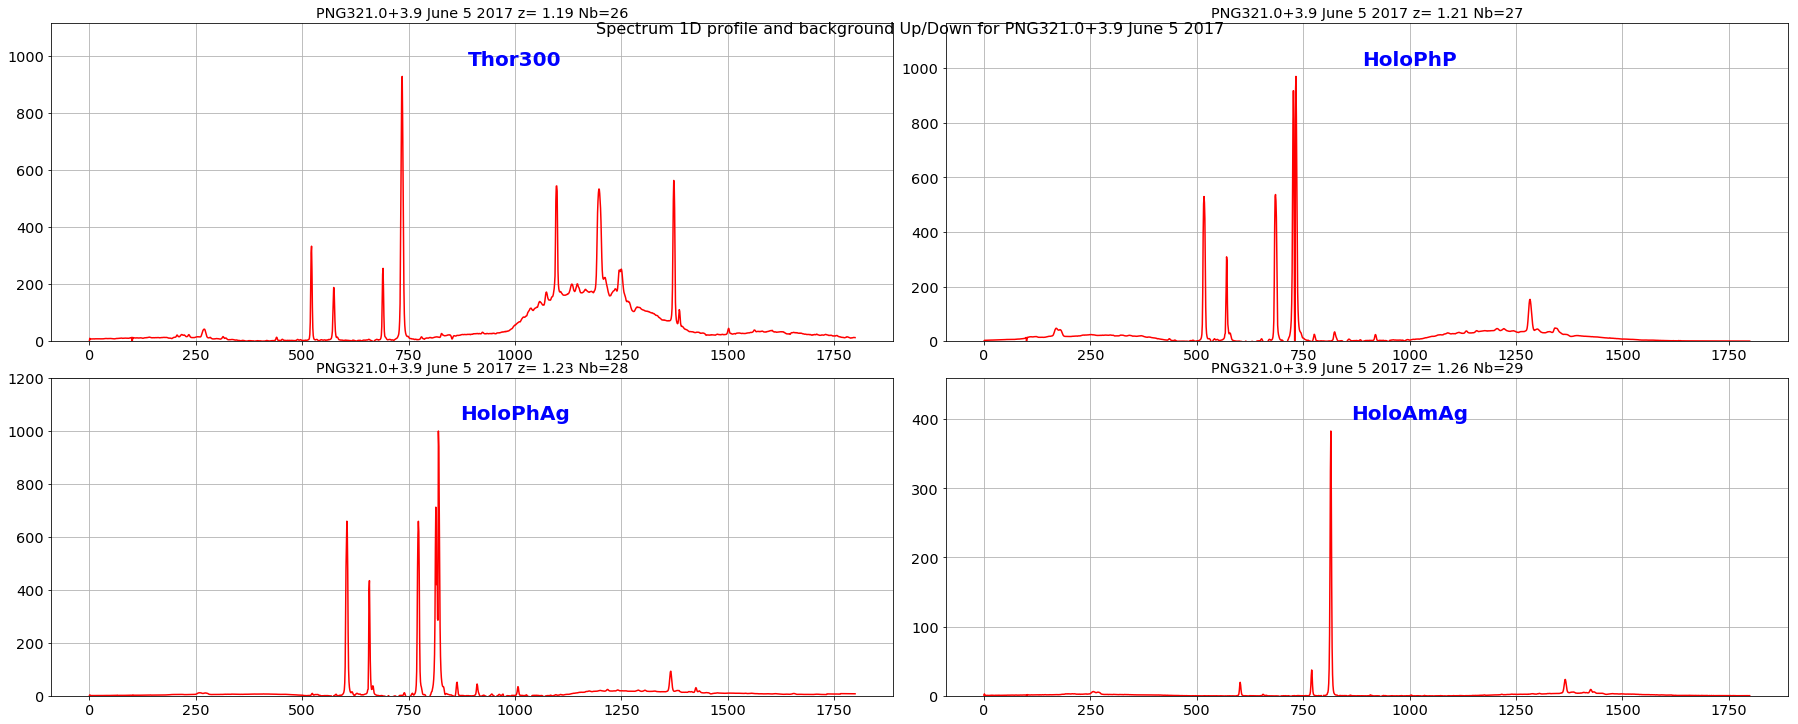

In [66]:
ShowSpectrumProfile(thecorrspectra,all_titles,object_name,dir_top_images,all_filt)

In [67]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os


def ShowSpectrumRightProfile2(spectra,all_titles,object_name,dir_top_images,all_filt):
    """
    ShowSpectrumProfile: Show the raw images without background subtraction
    =====================
    """
    NBIMGPERROW=2
    NBSPEC=len(spectra)
    MAXIMGROW=int(NBSPEC/NBIMGPERROW)
    #MaxY= [150.,150.,150.,5000.,1500.,1000.,5000.,5000.,500.,150.]
    
    ###############################
    left_cut = 1000
    right_cut = 1800
    ################################
    
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,5*MAXIMGROW))
    f.tight_layout()
    for index in np.arange(0,NBSPEC):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        axarr[iy,ix].plot(spectra[index],'r-')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,spectra[index][left_cut:right_cut].max()*1.2)
        axarr[iy,ix].set_xlim(left_cut,right_cut)
        axarr[iy,ix].text(1400.,spectra[index][left_cut:right_cut].max()*1.1, all_filt[index],verticalalignment='top', horizontalalignment='center',color='blue',fontweight='bold', fontsize=20)
    
    title='Spectrum 1D profile and background Up/Down for {}'.format(object_name)
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'correctedspectrum_profile2.pdf')
    plt.savefig(figfilename)  
    


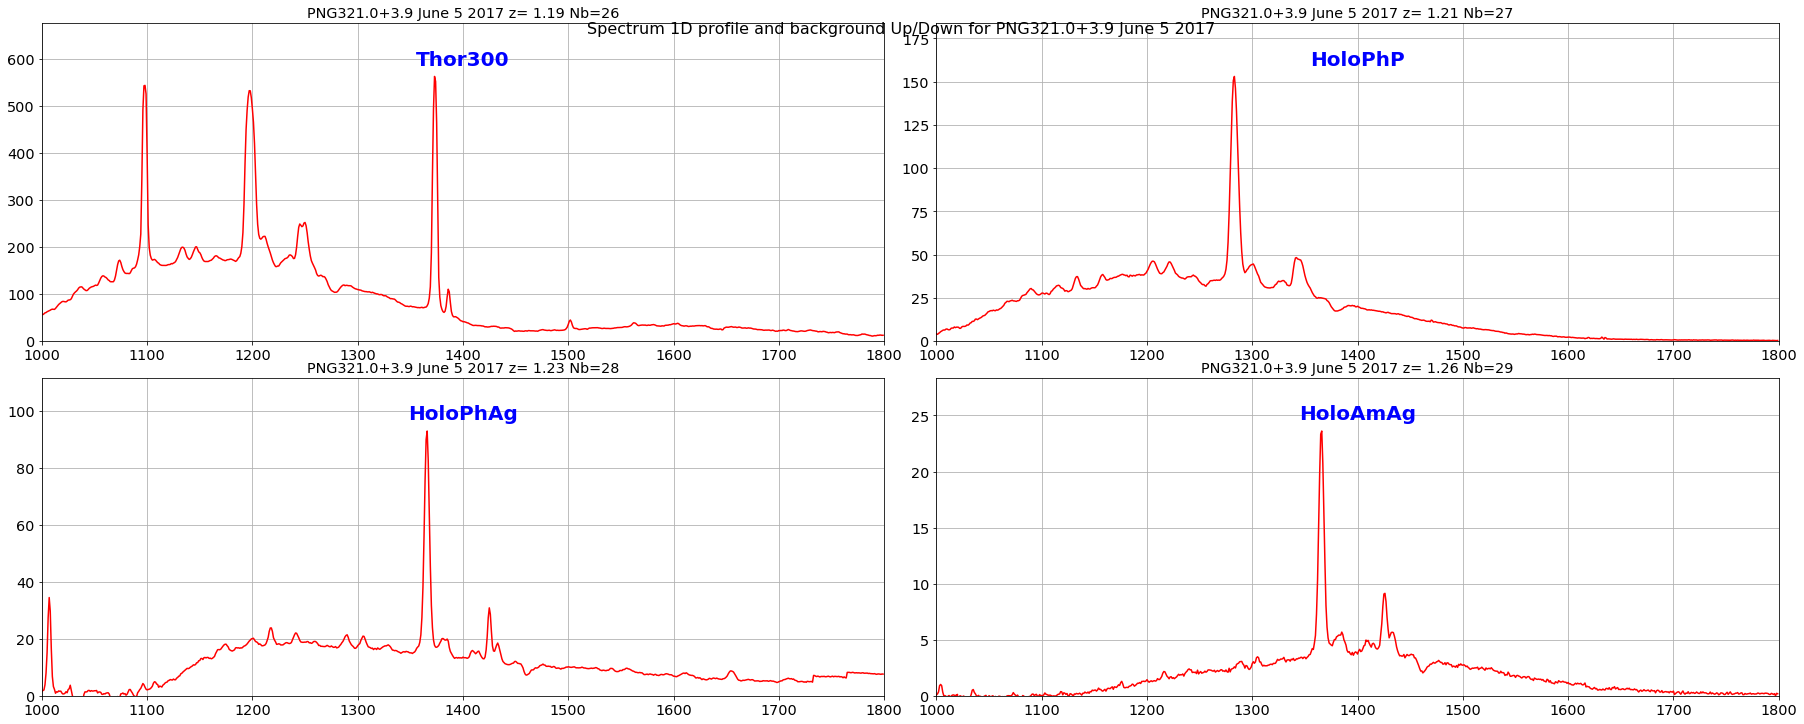

In [68]:
ShowSpectrumRightProfile2(thecorrspectra,all_titles,object_name,dir_top_images,all_filt)

## Ratio between amplitudes

In [69]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def SpectrumAmplitudeRatio(spectra):
    """
    SpectrumAmplitudeRatio: ratio of amplitudes
    =====================
    """
    ratio_list= []
    
    NBSPEC=len(spectra)
    
    for index in np.arange(0,NBSPEC):
       
        max_right=spectra[index][700:1900].max()
        max_left=spectra[index][:700].max()
        
        ratio=max_right/max_left
        ratio_list.append(ratio) 
        
    return ratio_list

In [70]:
ratio_of_maxamplitudes=SpectrumAmplitudeRatio(thecorrspectra)

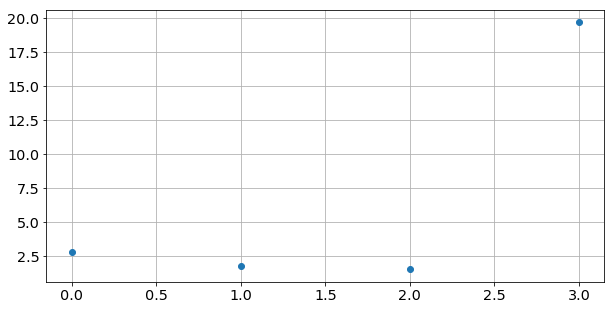

In [71]:
plt.figure(figsize=(10,5))
plt.plot(ratio_of_maxamplitudes,'o')
plt.grid()

In [72]:
print all_filt

['Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg']


## Example of a single spectrum

In [73]:
sel=0
spectrum_sel=thecorrspectra[sel]

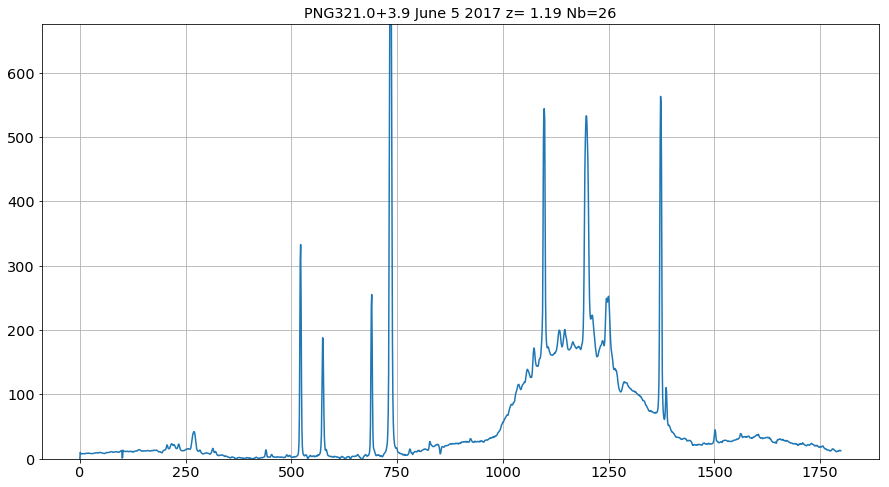

In [74]:
plt.figure(figsize=(15,8))
plt.plot(spectrum_sel)
title=all_titles[sel]
plt.title(title)
plt.grid(True)
plt.ylim(0,spectrum_sel[1000:1900].max()*1.2)
figfilename=os.path.join(dir_top_images,'singlespec_sample.pdf')
plt.savefig(figfilename) 

# Emission line identification

In [95]:
#%%cython
%load_ext autoreload
%autoreload 2
#import numpy as np
#import matplotlib.pyplot as plt
#import os

from holo_specs import *

def PNGLineIdentification(spectra,redshift,thex0,all_titles,object_name,dir_top_images,all_filt):
    """
    QSOLineIdentification show the right part of spectrum with identified lines
    =====================
    """
    NBSPEC=len(spectra)
    
    #target.load_spectra()
    
    ###############################
    left_cut = 1000
    right_cut = 1800
    #Ns =[346,348.5,300,354]   ########### temporary setting for plot
    ################################
    
    f, axarr = plt.subplots(NBSPEC,1,figsize=(20,7*NBSPEC))
    for index in np.arange(0,NBSPEC):

        spec = spectra[index][left_cut:right_cut]
        ######## convert pixels to wavelengths #########
        print all_filt[index]
        holo = Hologram(all_filt[index])
        #holo = Grating(Ns[index])
        print '-----------------------------------------------------'
        pixels = np.arange(left_cut,right_cut,1)-thex0[index]
        lambdas = holo.grating_pixel_to_lambda(pixels)
        
        axarr[index].plot(lambdas,spec,'r-',lw=2,label='Order +1 QSO spectrum')
    
        ######## set plot
        axarr[index].set_title(all_titles[index])
        axarr[index].text(600.,spec.max()*1.1, all_filt[index],verticalalignment='top', horizontalalignment='left',color='blue',fontweight='bold', fontsize=20)
        axarr[index].legend(fontsize=16)
        axarr[index].set_xlabel('Wavelength [nm]', fontsize=16)
        axarr[index].grid(True)
        axarr[index].set_ylim(0.,spec.max()*1.2)
        #axarr[index].set_xlim(np.min(lambdas),np.max(lambdas))
        axarr[index].set_xlim(400,900)
        plot_atomic_lines(axarr[index],redshift=redshift,atmospheric_lines=False)
    
    #title='Spectrum 1D profile and background Up/Down for {}'.format(object_name)
    #plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'PNG_correctedspectrum_profile.pdf')
    plt.savefig(figfilename)  
    


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Thor300
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -0.6 degrees
N = 299.41 +/- 0.88 grooves/mm
Hologram center at x0 = 1398.0 and y0 = 1264.0 with average tilt of -0.6 degrees
Plate center at x0 = 774.0 and y0 = 690.7 with average tilt of -0.6 degrees
Order  0 position at x0 = 1132.4 and y0 = 1266.7
Order +1 position at x0 = 1663.6 and y0 = 1261.3
Distance between the orders: 531.21 pixels (12.75 mm)
-----------------------------------------------------
HoloPhP
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -1.0 degrees
N = 355.08 +/- 1.03 grooves/mm
Hologram center at x0 = 843.0 and y0 = 629.0 with average tilt of -1.0 degrees
Plate center at x0 = 774.0 and y0 = 690.7 with average tilt of -1.0 degrees
Order  0 position at x0 = 577.4 and y0 = 633.7
Order +1 position at x0 = 1108.6 and y0 = 624.3
Distance between the orders: 531.21 pixels (12.75 mm)
-----------------------------------------------------
HoloPhAg
Grating plate center

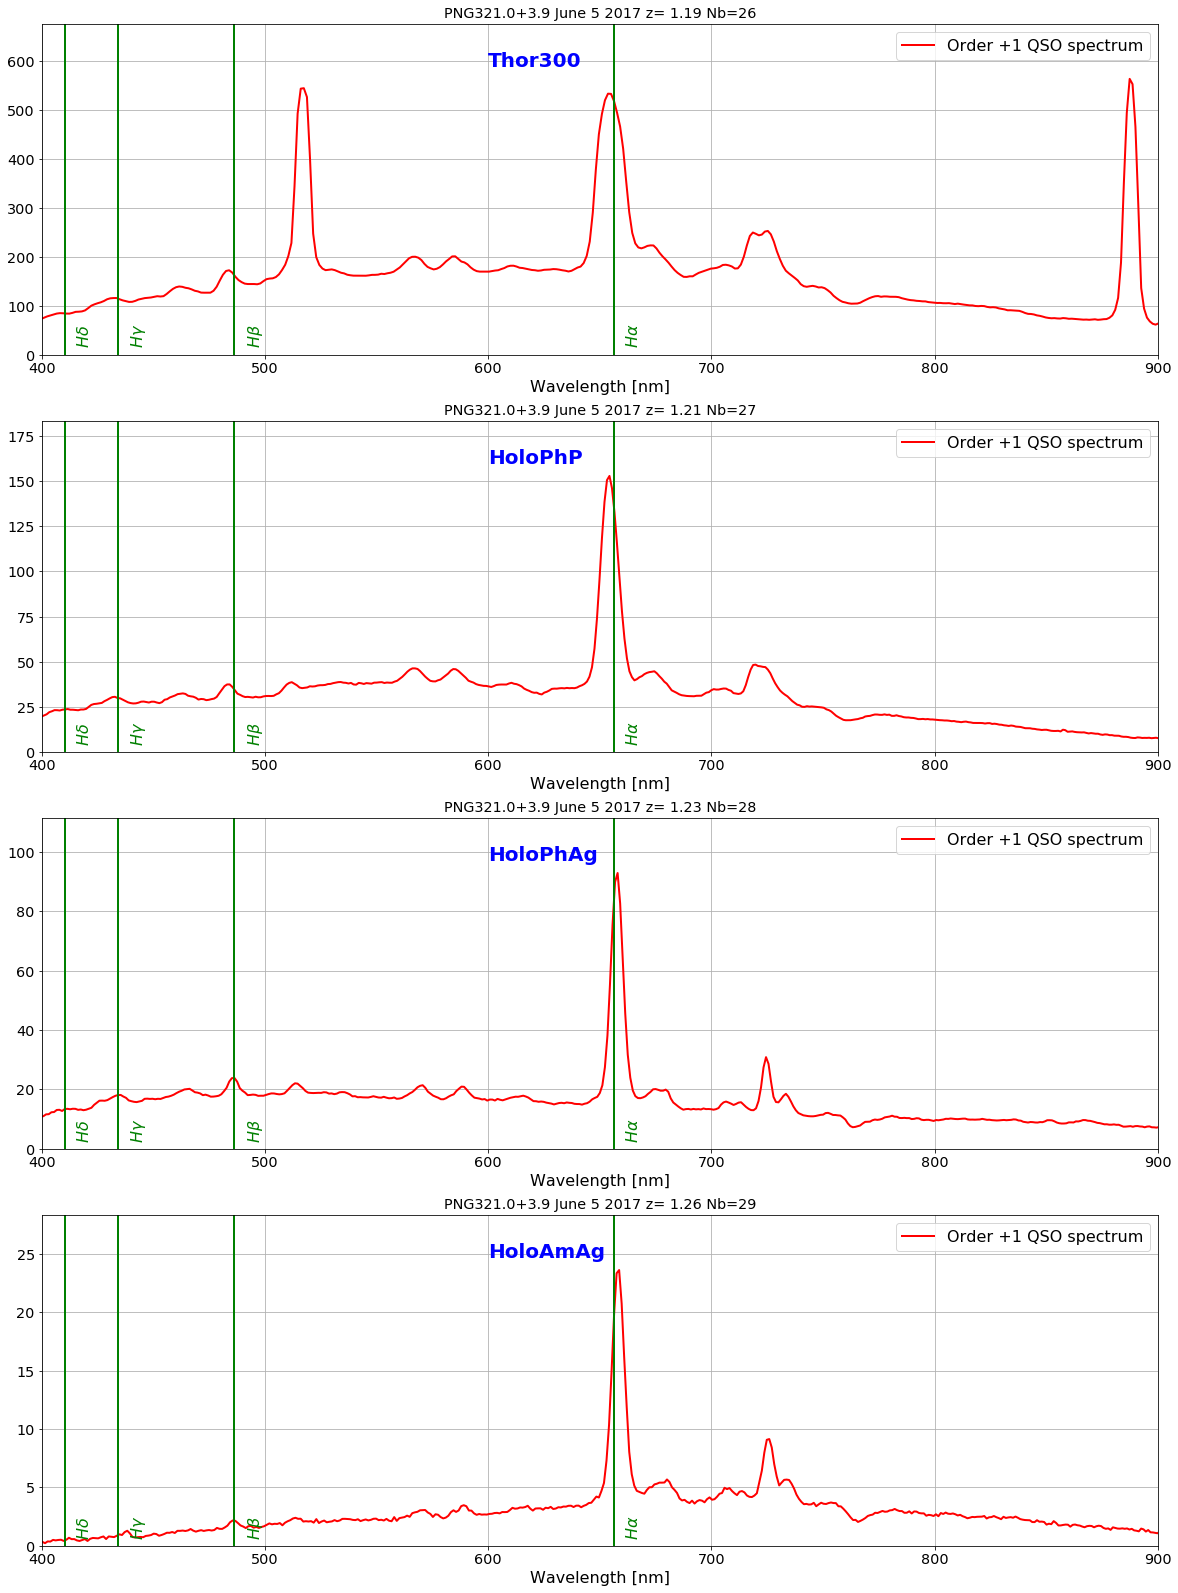

In [96]:
QSO_3C273_REDSHIFT = 0.158

from targets import *

#QSO = Target("PNG321.0+3.9")

PNGLineIdentification(thecorrspectra,0,thex0,all_titles,object_name,dir_top_images,all_filt)

### Main conclusions

- The lines are bright but the background substraction was difficult close to the circular mask : make squared mask !
- The hologram effective grooves per mm number is overestimated for holograms : variations depending on the pointing ?
- FWHMs are ...

## Save results

In [77]:
#for index in range(len(all_filt)):
#    holo_name = all_filt[index]
#    dirname = "../../common_tools/data/"+holo_name
#    ensure_dir(dirname)
#    print 'Save results in ',dirname
#    np.savetxt(dirname+'/N.txt',[Ns[index],N_errs[index]])

In [78]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[2]
    short_partfilename=re.findall('^rotimg_(.*)',short_infilename)
    short_outfilename='finalSpectra_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

In [79]:
newfullfilenames

['./spectrum_fitsspec/finalSpectra_20170605_026.fits',
 './spectrum_fitsspec/finalSpectra_20170605_027.fits',
 './spectrum_fitsspec/finalSpectra_20170605_028.fits',
 './spectrum_fitsspec/finalSpectra_20170605_029.fits']

### Save outputfilename

In [80]:
#
#  New fashion to save a binary table outside the primary header
#
for idx,file in np.ndenumerate(newfullfilenames):
    primhdu = fits.PrimaryHDU(header=all_header[idx[0]])   # make an primary HDU without data
    
    col1=fits.Column(name='RawLeftSpec',format='E',array=spectra_left[idx[0]])
    col2=fits.Column(name='RawRightSpec',format='E',array=spectra_right[idx[0]])
    cols=fits.ColDefs([col1,col2])
    
    tbhdu = fits.BinTableHDU.from_columns(cols)     # new binary table HDU
    thdulist = fits.HDUList([primhdu, tbhdu])
    
    thdulist.writeto(file,clobber=True)

NameError: name 'spectra_left' is not defined